# Selezione del modello

In questo notebook proveremo alcuni metodi di selezione dei modelli. Partendo dai due modelli con le migliori performance del notebook 3 cercheremo i valori ottimali degli iperparametri, valutando varie configurazioni tramite cross-validation. Successivamente testeremo la migliore configurazione sul test set.

Per prima cosa importiamo i dati e alcune librerie.

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="600" height="400">


In [1]:
import warnings
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
def get_data(filename: str) -> tuple:
    path = os.path.join("datasets", filename)
    with open(path, "rb") as file:
        data = pickle.load(file)
    return data

In [3]:
classification_data = get_data("classification_data.pickle")
regression_data = get_data("regression_data.pickle")

## Selezione degli iperparametri - Classificazione

Nel notebook precedente abbiamo scelto `RandomForestClassifier` come modello principale per il problema di classificazione.
Ora selezioneremo gli iperparametri del modello tramite lo score di 5-fold cross-validation sul train set.

In genere questo processo viene svolto congiuntamente alla selezione del modello candidato, in modo da avere una visione più completa delle possibili performance del modello.

A tale scopo utilizzeremo la funzione `cross_val_score` di `sklearn`, che ci permette di automatizzare il processo di cross-validation.


In [4]:
X_train, y_train, X_test, y_test = classification_data

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

# Perform a 10-fold cross validation
scores = cross_val_score(rfc, X_train, y_train, cv=10)

,Random Forest CV
1,0.760741
2,0.742222
3,0.753333
4,0.743704
5,0.763704
6,0.746667
7,0.731852
8,0.759259
9,0.765926
10,0.751852


'Mean: Random Forest CV    0.751926\ndtype: float64'

<Axes: ylabel='Frequency'>

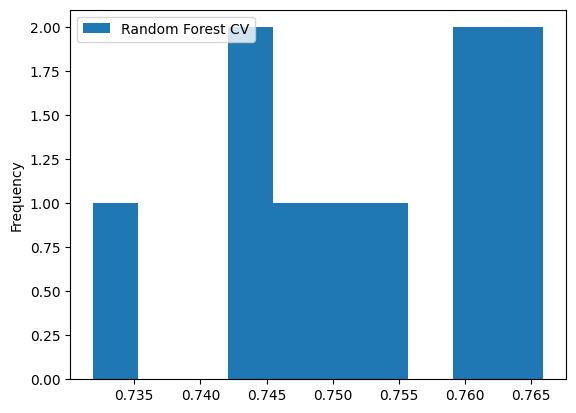

In [6]:
scores = pd.DataFrame(
    scores, columns=["Random Forest CV"], index=np.arange(1, scores.shape[0] + 1)
)
display(scores, f"Mean: {scores.mean()}")
scores.plot.hist()

Applichiamo ora il metodo per trovare dei buoni parametri per il modello. A tale scopo dovremo scegliere uno spazio dei parametri da esplorare e un metodo per farlo. Qui proponiamo 3 approcci possibili.


### Metodo 1 - GridSearchCV

Utilizzeremo il metodo `GridSearchCV` di `sklearn`, che permette di esplorare uno spazio dei parametri con una ricerca esaustiva.


In [7]:
params = {
    # 'n_estimators' rappresenta il numero di alberi nella foresta. Di solito il
    # numero più alto di alberi è il migliore per apprendere i dati. Tuttavia,
    # aggiungendo molti alberi può rallentare notevolmente il processo di addestramento,
    # quindi di solito usiamo un numero ragionevole a seconda delle dimensioni del dataset.
    "n_estimators": [10, 50],
    # 'max_depth' rappresenta la profondità di ciascun albero nella foresta.
    # Più profondo è l'albero, più suddivisioni ha e cattura più informazioni sui dati
    # e questa è la profondità massima a cui può crescere ciascun albero.
    "max_depth": [1, 3],
    # 'min_samples_split' rappresenta il numero minimo di campioni necessari per dividere un nodo interno.
    # Questo può variare tra considerare almeno un campione in ciascun nodo
    # a considerare tutti i campioni in ciascun nodo. Quando aumentiamo questo parametro,
    # l'albero diventa più vincolato in quanto deve considerare più campioni in ciascun nodo.
    "min_samples_split": [2, 5],
    # 'min_samples_leaf' è il numero minimo di campioni richiesti per essere in un nodo foglia.
    # Questo parametro è simile a min_samples_splits, tuttavia, descrive il numero minimo di
    # campioni alle foglie, alla base dell'albero.
    "min_samples_leaf": [2, 4],
    # 'max_features' rappresenta il numero di caratteristiche da considerare quando si cerca
    # la migliore suddivisione. Queste saranno selezionate in modo casuale.
    # Come regola generale, la radice quadrata del numero totale di caratteristiche funziona
    # spesso molto bene, ma dovremmo controllare fino al 30-40% del numero totale di features.
    "max_features": ["sqrt", "log2"],
    # 'bootstrap' viene utilizzato per il campionamento avviato. Ciò significa che per ogni albero
    # che viene costruito, considererebbe un insieme / sottoinsieme di righe distinte. Generalmente,
    # l'opzione di avvio è impostata su True per un modello Random Forest.
    "bootstrap": [True, False],
    # 'criterion' è la funzione per misurare la qualità di una divisione. "gini" è per l'impurità di Gini
    # e "entropy" è per il guadagno di informazione.
    "criterion": ["gini", "entropy"],
}

# Una funzione per contare il numero di combinazioni possibili:


def count_combinations(params: dict) -> int:
    result = 1
    for key in params:
        subset_count = 1
        if isinstance(params[key], list):
            subset_count = len(params[key])
        elif isinstance(params[key], dict):
            subset_count = count_combinations(params[key])
        result *= subset_count
    print("Number of combinations: ", result)


count_combinations(params)

Number of combinations:  128


In [8]:
from sklearn.model_selection import GridSearchCV

# Creiamo un oggetto GridSearchCV
grid_search = GridSearchCV(
    estimator=rfc, param_grid=params, cv=5, n_jobs=-1
)  # per mostrare l'andamento della run, si può usare verbose=2

# Eseguiamo la grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'], 'max_depth': [1, 3],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 50]})

Ora possiamo estrarre la configurazione ottimale dall'oggetto:


In [9]:
best_params = grid_search.best_params_
print(
    "Best hyperparameters:\n",
    best_params,
    "\nwith GridSearchCV best score: {:.2%}".format(grid_search.best_score_),
)

Best hyperparameters:
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10} 
with GridSearchCV best score: 72.87%


Ora possiamo allenare il modello con la configurazione ottimale su tutto il train set e testarlo sul test set.


In [10]:
# Impostiamo i parametri ottimali per il modello
rfc.set_params(**best_params)

# Alleniamo il modello sul train set
rfc.fit(X_train, y_train)

# Calcoliamo le previsioni del modello sul test set
y_pred = rfc.predict(X_test)

              precision    recall  f1-score   support

           0       0.72      0.97      0.83      1019
           1       0.79      0.21      0.33       481

    accuracy                           0.73      1500
   macro avg       0.75      0.59      0.58      1500
weighted avg       0.74      0.73      0.67      1500



<Axes: >

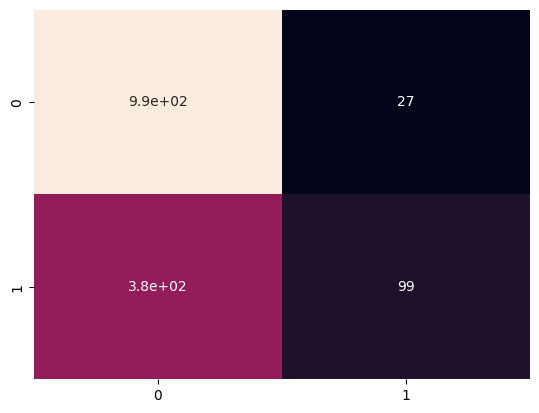

In [11]:
# Infine valutiamo le previsioni
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Visualizziamo il classification report e la confusion matrix
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False)

### Metodo 2 - RandomizedSearchCV

A volte, specie se lo spazio dei parametri è molto grande e/o il modello complesso da allenare, la ricerca esaustiva può diventare estremamente costosa. Potrebbe quindi essere più ragionevole campionare lo spazio degli iperparametri. Un possibile metodo è il campionamento casuale di `RandomizedSearchCV`.


In [12]:
from sklearn.model_selection import RandomizedSearchCV

# Definiamo un nuovo spazio dei parametri
more_params = {
    "n_estimators": list(range(50, 101, 10)),
    "max_depth": list(range(3, 11)),
    "min_samples_split": list(range(2, 4)),
    "min_samples_leaf": list(range(3, 6)),
    "max_features": ["sqrt"],
    "bootstrap": [True],
    "criterion": ["gini"],
}
count_combinations(more_params)

Number of combinations:  288


In [13]:
# Creiamo un oggetto RandomizedSearchCV
random_search = RandomizedSearchCV(
    rfc, more_params, n_iter=50, cv=5, n_jobs=-1, random_state=42
)

# Eseguiamo la random search
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=3,
                                                    min_samples_leaf=4,
                                                    n_estimators=10,
                                                    random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['gini'],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [2, 3],
                                        'n_estimators': [50, 60, 70, 80, 90,
                                                         100]},
                   random_state=42)

Come prima estraiamo la combinazione ottimale, fittiamo sul train e calcoliamo lo score.


In [14]:
# Visualizziamo i parametri ottimali
best_params = random_search.best_params_
print(
    "Best hyperparameters:\n",
    best_params,
    "\nwith RandomizedSearchCV best score: {:.2%}".format(random_search.best_score_),
)

Best hyperparameters:
 {'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'gini', 'bootstrap': True} 
with RandomizedSearchCV best score: 75.93%


              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1019
           1       0.70      0.38      0.49       481

    accuracy                           0.75      1500
   macro avg       0.73      0.65      0.66      1500
weighted avg       0.74      0.75      0.72      1500



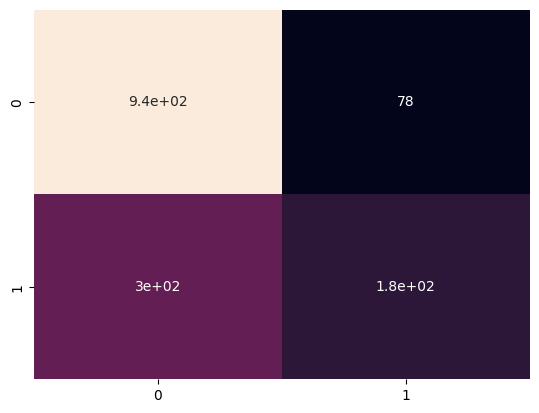

In [15]:
# Impostiamo i parametri ottimali per il modello
rfc.set_params(**best_params)

# Alleniamo il modello sul train set
rfc.fit(X_train, y_train)

# Calcoliamo le previsioni del modello sul test set
y_pred = rfc.predict(X_test)

# Infine valutiamo le previsioni
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False)
print(classification_report(y_test, y_pred))

### Metodo 3 - Ray

[Ray](https://docs.ray.io/en/latest/tune/index.html) è una libreria che offre diverse funzionalità utili per la creazione di modelli di ML, come gestione del training distribuito, logging e ottimizzazione degli iperparametri.

Nel nostro caso utilizzeremo l'algoritmo offerto dalla libreria [Hyperopt](http://hyperopt.github.io/hyperopt/), che utilizza un metodo chiamato [Tree Parzen Estimator](https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf).

Per prima cosa dobbiamo preparare lo spazio dei parametri da utilizzare. A differenza dei metodi precedenti, in questo caso i range delle singole variabili vanno specificati usando gli [strumenti offerti dalla libreria](https://docs.ray.io/en/latest/tune/api/search_space.html).


In [16]:
from ray import tune, train

# Definiamo un nuovo search space utilizzando le distribuzioni di probabilità
search_space = {
    "n_estimators": tune.lograndint(10, 1000),
    "max_depth": tune.randint(1, 10),
    "min_samples_split": tune.randint(2, 10),
    "min_samples_leaf": tune.randint(1, 10),
    "max_features": tune.choice(["sqrt", "log2"]),
    "bootstrap": tune.choice([True, False]),
    "criterion": tune.choice(["gini", "entropy"]),
}

Ora costruiamo la funzione che Ray andrà ad ottimizzare.


In [17]:
# Definiamo la funzione obiettivo
def objective(config):
    # Creiamo un modello con i parametri specificati e eseguimo una cross validation
    score = cross_val_score(RandomForestClassifier(**config), X_train, y_train, cv=5)
    # Ritorniamo la media delle accuracy
    train.report({"score": score.mean()})

Ora possiamo ottimizzare questa funzione (quindi massimizzare lo score rispetto agli iperparametri) utilizzando la classe `Tuner`.


In [18]:
from ray.tune.search.hyperopt import HyperOptSearch

# Creiamo un oggetto Tuner
tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        search_alg=HyperOptSearch(random_state_seed=42),
        num_samples=50,
        metric="score",
        mode="max",
    ),
    param_space=search_space,
)

# Eseguiamo la ricerca
results = tuner.fit()

(raylet) [2023-10-22 19:31:09,663 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4378357760; capacity: 132833185792. Object creation will fail if spilling is required.
(raylet) [2023-10-22 19:31:19,672 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4378296320; capacity: 132833185792. Object creation will fail if spilling is required.
(raylet) [2023-10-22 19:31:29,682 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4378279936; capacity: 132833185792. Object creation will fail if spilling is required.
(raylet) [2023-10-22 19:31:39,693 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4378275840; capacity: 132833185792. Object creation wil

Infine valutiamo le performance del modello con questi parametri, allenato sul train set e valutato sul test set.


Best hyperparameters:
 {'n_estimators': 94, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini'} 
with best mean score: 75.99%


(raylet) [2023-10-22 19:41:40,176 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4375969792; capacity: 132833185792. Object creation will fail if spilling is required.


              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1019
           1       0.71      0.42      0.53       481

    accuracy                           0.76      1500
   macro avg       0.74      0.67      0.68      1500
weighted avg       0.75      0.76      0.74      1500



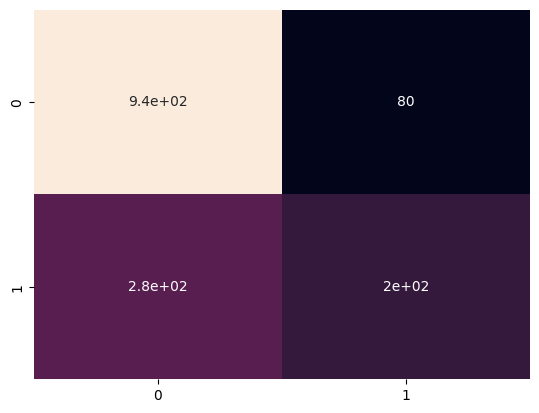

In [19]:
# Visualizziamo i parametri ottimali
best_score = results.get_best_result().metrics["score"]
best_params = results.get_best_result().config
print(
    "Best hyperparameters:\n",
    best_params,
    "\nwith best mean score: {:.2%}".format(best_score),
)

# Impostiamo i parametri ottimali per il modello
rfc.set_params(**best_params)

# Alleniamo il modello sul train set
rfc.fit(X_train, y_train)

# Calcoliamo le previsioni del modello sul test set
y_pred = rfc.predict(X_test)

# Infine valutiamo le previsioni
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False)
print(classification_report(y_test, y_pred))

Notiamo che, fra i tre metodi, questo ci ha dato il modello migliore in tempi minimali.


## Selezione degli iperparametri - Regressione

Ripetiamo ora il processo appena attuato, questa volta per il nostro modello di regressione, `XGBRegressor`. Dato che conosciamo già i metodi principali, ci concentreremo sull'arricchire le informazioni ottenute dalla cross-validation, perciò useremo la funzione `cross_validate` di `sklearn`.


In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate

# Importiamo i dati necessari
X_train, y_train, X_test, y_test = regression_data

# Testiamo cross_validate
score_names = [
    "neg_mean_squared_error",
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
]
scores = cross_validate(XGBRegressor(), X_train, y_train, cv=5, scoring=score_names)


# Definiamo una funzione per ottenere le metriche attese (medie sulle fold e con segno positivo)
def fix_scores(scores):
    fixed_scores = dict()
    for key in scores:
        if "test_" in key:
            fixed_scores[key.replace("test_neg_", "")] = -scores[key].mean()
        else:
            fixed_scores[key] = scores[key].mean()
    return fixed_scores


display(scores, fix_scores(scores))

{'fit_time': array([0.23320723, 0.26569462, 0.23305845, 0.22646236, 0.22422647]),
 'score_time': array([0.00960994, 0.00996327, 0.01785827, 0.0096364 , 0.01005888]),
 'test_neg_mean_squared_error': array([-1.03483171, -1.06176841, -1.10681787, -0.99161405, -1.04561965]),
 'test_neg_root_mean_squared_error': array([-1.01726678, -1.03042147, -1.05205412, -0.9957982 , -1.02255545]),
 'test_neg_mean_absolute_error': array([-0.79268892, -0.80680174, -0.83168042, -0.78243914, -0.80839867])}

{'fit_time': 0.23652982711791992,
 'score_time': 0.011425352096557618,
 'mean_squared_error': 1.0481303367575998,
 'root_mean_squared_error': 1.0236192041277468,
 'mean_absolute_error': 0.8044017779433139}

Notiamo alcune cose:

- La funzione `cross_validate` ci dà più informazioni riguardo a ciascuna fold dei dati
- Questa funzione ci permette di usare più di una metrica alla volta
- Le metriche di regressione rese disponibili da `sklearn` hanno il segno negativo (quindi vogliamo massimizzarle).

Possiamo ora passare alla selezione degli iperparametri usando `ray`, questa volta con più informazioni disponibili.


In [21]:
# Creiamo uno spazio di iperparametri da esplorare
search_space = {
    # Il numero di alberi da costruire
    "n_estimators": tune.choice([100, 200, 300, 400, 500]),
    # La profondità massima di ogni albero
    "max_depth": tune.randint(1, 7),
    # Il tasso di apprendimento, che controlla il peso dei nuovi alberi aggiunti al modello
    "learning_rate": tune.loguniform(0.001, 0.1),
    # Il parametro di regolarizzazione che riduce l'overfitting penalizzando i pesi degli alberi
    "gamma": tune.uniform(0, 1),
    # Il parametro di regolarizzazione L2 che controlla la complessità dei pesi delle foglie
    "reg_lambda": tune.uniform(0, 10),
    # Il parametro di regolarizzazione L1 che controlla la sparsità dei pesi delle foglie
    "reg_alpha": tune.uniform(0, 10),
    # La frazione di osservazioni da campionare per ogni albero
    "subsample": tune.uniform(0.5, 1),
    # La frazione di colonne da campionare per ogni albero
    "colsample_bytree": tune.uniform(0.5, 1),
    # La funzione obiettivo da usare per il modello (ad esempio regressione lineare o regressione logistica)
    "objective": tune.choice(["reg:squarederror", "reg:absoluteerror"]),
}


# Definiamo una nuova funzione obiettivo
def objective(config):
    scores = cross_validate(
        XGBRegressor(**config),
        X_train,
        y_train,
        cv=5,
        scoring=score_names,
        error_score="raise",
    )
    fixed_scores = fix_scores(scores)
    train.report(fixed_scores)


# Creiamo un oggetto Tuner
tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        search_alg=HyperOptSearch(random_state_seed=42),
        num_samples=100,
        metric="root_mean_squared_error",
        mode="min",
    ),
    param_space=search_space,
)

# Eseguiamo la ricerca
results = tuner.fit()

(raylet) [2023-10-22 19:41:50,184 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4375855104; capacity: 132833185792. Object creation will fail if spilling is required.
(raylet) [2023-10-22 19:42:00,192 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4375724032; capacity: 132833185792. Object creation will fail if spilling is required.
(raylet) [2023-10-22 19:42:10,199 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4375580672; capacity: 132833185792. Object creation will fail if spilling is required.
(raylet) [2023-10-22 19:42:20,205 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4375486464; capacity: 132833185792. Object creation wil

In [22]:
results.get_best_result().metrics

{'fit_time': 0.15357551574707032,
 'score_time': 0.0065500736236572266,
 'mean_squared_error': 0.9370155536057376,
 'root_mean_squared_error': 0.9678092528045052,
 'mean_absolute_error': 0.7538661819104802,
 'timestamp': 1697996701,
 'done': True,
 'training_iteration': 1,
 'trial_id': 'cdb923b4',
 'date': '2023-10-22_19-45-01',
 'time_this_iter_s': 0.8078789710998535,
 'time_total_s': 0.8078789710998535,
 'pid': 32832,
 'hostname': 'development',
 'node_ip': '172.18.13.4',
 'config': {'n_estimators': 200,
  'max_depth': 2,
  'learning_rate': 0.06062200053528221,
  'gamma': 0.7143569444657896,
  'reg_lambda': 5.988379302415865,
  'reg_alpha': 4.697377794059866,
  'subsample': 0.6145201425549485,
  'colsample_bytree': 0.5693963997884186,
  'objective': 'reg:squarederror'},
 'time_since_restore': 0.8078789710998535,
 'iterations_since_restore': 1,
 'checkpoint_dir_name': None,
 'experiment_tag': '75_colsample_bytree=0.5694,gamma=0.7144,learning_rate=0.0606,max_depth=2,n_estimators=200,ob

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualizziamo i parametri ottimali
best_mse = results.get_best_result().metrics["mean_squared_error"]
best_rmse = results.get_best_result().metrics["root_mean_squared_error"]
best_mae = results.get_best_result().metrics["mean_absolute_error"]
best_params = results.get_best_result().config
print(
    "Best hyperparameters:\n",
    best_params,
    "\nwith scores:\nMSE: ",
    best_mse,
    "RMSE: ",
    best_rmse,
    "MAE: ",
    best_mae,
)

# Creiamo un modello XGBRegressor
xgbr = XGBRegressor()
# Impostiamo i parametri ottimali per il modello
xgbr.set_params(**best_params)

# Alleniamo il modello sul train set
xgbr.fit(X_train, y_train)

# Calcoliamo le previsioni del modello sul test set
y_pred = xgbr.predict(X_test)

print(
    f"Best model test scores:\nMSE: {mean_squared_error(y_test,y_pred)}\nRMSE: {mean_squared_error(y_test,y_pred, squared=False)}\nMAE: {mean_absolute_error(y_test,y_pred)}"
)

Best hyperparameters:
 {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.06062200053528221, 'gamma': 0.7143569444657896, 'reg_lambda': 5.988379302415865, 'reg_alpha': 4.697377794059866, 'subsample': 0.6145201425549485, 'colsample_bytree': 0.5693963997884186, 'objective': 'reg:squarederror'} 
with scores:
MSE:  0.9370155536057376 RMSE:  0.9678092528045052 MAE:  0.7538661819104802
Best model test scores:
MSE: 0.9075613422639787
RMSE: 0.9526601399575709
MAE: 0.7455886532309288


(raylet) [2023-10-22 19:46:00,381 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4371361792; capacity: 132833185792. Object creation will fail if spilling is required.


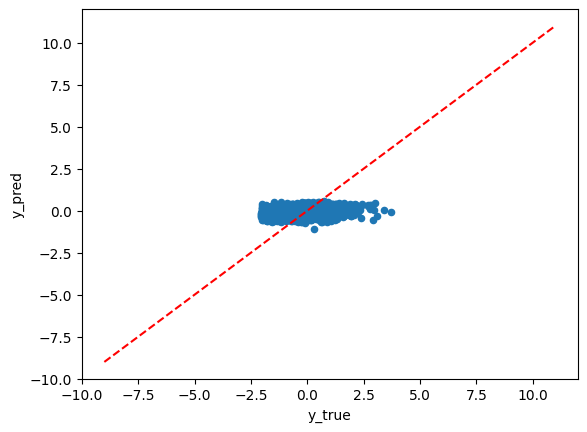

In [24]:
import matplotlib.pyplot as plt

# Visualizziamo i risultati
results_df = pd.DataFrame({"y_true": y_test, "y_pred": y_pred})

fig, ax = plt.subplots()
results_df.plot.scatter("y_true", "y_pred", ax=ax)
ax.plot(range(-9, 12), range(-9, 12), linestyle="dashed", color="red")

## Salvataggio e caricamento dei modelli scelti

Utilizzando i file pickle possiamo facilmente salvare i nostri modelli come artefatti per riutilizzarli successivamente.


In [25]:
# Creazione della cartella per salvare i modelli
if not os.path.exists("models"):
    os.mkdir("models")

# Salvataggio dei modelli
with open("models/classification_model.pickle", "wb") as file:
    pickle.dump(rfc, file)
with open("models/regression_model.pickle", "wb") as file:
    pickle.dump(xgbr, file)

Ora possiamo reimportarli ed applicarli ad un dataset:

In [26]:
# Esempio: reimportiamo il modello XGBRegressor e lo applichiamo di nuovo al test set

with open("models/regression_model.pickle", "rb") as file:
    xgbr = pickle.load(file)
new_y_pred = xgbr.predict(X_test)

# Compariamo i risultati ottenuti con quelli precedenti
print(
    f"Best model test scores:\nMSE: {mean_squared_error(y_test,new_y_pred)}\nRMSE: {mean_squared_error(y_test,new_y_pred, squared=False)}\nMAE: {mean_absolute_error(y_test,new_y_pred)}"
)

Best model test scores:
MSE: 0.9075613422639787
RMSE: 0.9526601399575709
MAE: 0.7455886532309288


(raylet) [2023-10-22 19:46:10,411 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4389986304; capacity: 132833185792. Object creation will fail if spilling is required.
(raylet) [2023-10-22 19:46:20,448 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4389986304; capacity: 132833185792. Object creation will fail if spilling is required.
(raylet) [2023-10-22 19:46:30,486 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4389978112; capacity: 132833185792. Object creation will fail if spilling is required.
(raylet) [2023-10-22 19:46:40,522 E 32462 32477] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-10-22_19-30-57_271318_32332 is over 95% full, available space: 4389978112; capacity: 132833185792. Object creation wil